**0. Installing Dependencies**

In [1]:
#Dependencies
%pip install openpyxl matplotlib pandas darts statsmodels -q


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python3.11 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
file_path = '../../Data/EnergieUebersichtCH-2024.xlsx' 
total = 29000

**1. Retrieving Data**

In [3]:
import pandas as pd
file_path = '../../Data/EnergieUebersichtCH-2024.xlsx' 
xls = pd.ExcelFile(file_path)
#Dataframe in this case in the 3rd sheet Zeitreihen0h15
df = pd.read_excel(xls, sheet_name='Zeitreihen0h15', header=1, nrows=total)
print(df.columns)


Index(['Zeitstempel', 'kWh', 'kWh.1', 'kWh.2', 'kWh.3', 'kWh.4', 'kWh.5',
       'kWh.6', 'kWh.7', 'kWh.8', 'kWh.9', 'kWh.10', 'kWh.11', 'kWh.12',
       'kWh.13', 'kWh.14', 'kWh.15', 'kWh.16', 'kWh.17', 'kWh.18', 'kWh.19',
       'Euro/MWh', 'Euro/MWh.1', 'Euro/MWh.2', 'Euro/MWh.3', 'kWh.20',
       'kWh.21', 'kWh.22', 'kWh.23', 'kWh.24', 'kWh.25', 'kWh.26', 'kWh.27',
       'kWh.28', 'kWh.29', 'kWh.30', 'kWh.31', 'kWh.32', 'kWh.33', 'kWh.34',
       'kWh.35', 'kWh.36', 'kWh.37', 'kWh.38', 'kWh.39', 'kWh.40', 'kWh.41',
       'kWh.42', 'kWh.43', 'kWh.44', 'kWh.45', 'kWh.46', 'kWh.47', 'kWh.48',
       'kWh.49', 'kWh.50', 'kWh.51', 'kWh.52', 'kWh.53', 'kWh.54', 'kWh.55',
       'kWh.56', 'kWh.57', 'kWh.58', 'kWh.59'],
      dtype='object')


1.1 Aggregate Data by day

In [4]:
df['Zeitstempel'] = pd.to_datetime(
    df['Zeitstempel'],
    format='%d.%m.%Y %H:%M',   
    dayfirst=True,            
    errors='raise'            
)



In [5]:
df['Zeitstempel'] = pd.to_datetime(df['Zeitstempel'])
df = df.set_index('Zeitstempel')
df = df.resample('24H').sum()
df = df.drop(df.tail(1).index)

Recalculate total by 24h

In [6]:
total = int ((total / 96) -1) 
print(total)

301


**2. Data variables / potential parameters** 

**Pre-processing step** Renaming column names to be clear

In [7]:
column_mapping = { 
    'kWh': 'Total Energy Consumed by End Users (kWh)',
    'kWh.1': 'Total Energy Production (kWh)',
    'kWh.2': 'Total Energy Consumption (kWh)',
    'kWh.3': 'Net Outflow (kWh)',
    'kWh.4': 'Grid Feed-In (kWh)',
    'kWh.5': 'Positive Secondary Control Energy (kWh)',
    'kWh.6': 'Negative Secondary Control Energy (kWh)',
    'kWh.7': 'Positive Tertiary Control Energy (kWh)',
    'kWh.8': 'Negative Tertiary Control Energy (kWh)'
}

df.rename(columns=column_mapping, inplace=True)

The goal is to predict the next element of the Total Energy Consumption columb:

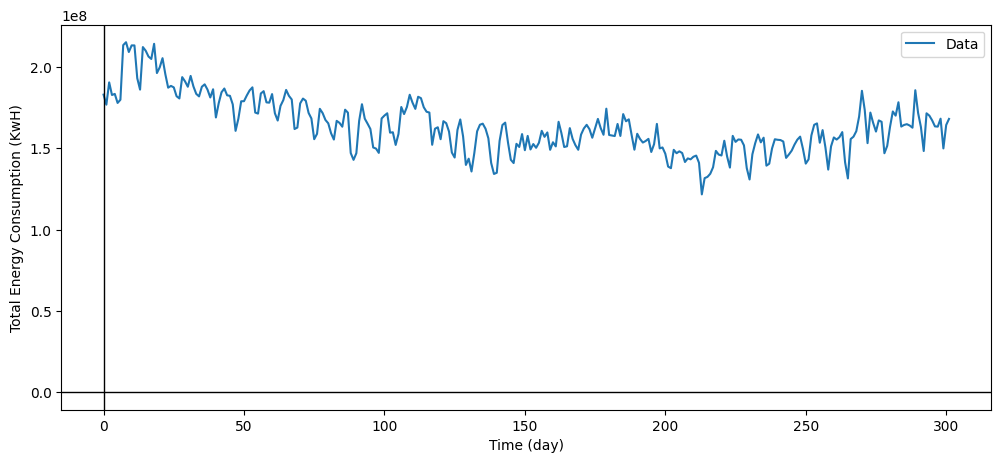

In [8]:
energy_consumption_data = df['Total Energy Consumption (kWh)'].dropna().values 
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 5))
plt.plot(energy_consumption_data, label='Data')
plt.xlabel('Time (day)')
plt.ylabel('Total Energy Consumption (KwH)')
plt.axhline(0, color='black', linewidth=1)
plt.axvline(0, color='black', linewidth=1)

plt.plot(range(len(energy_consumption_data), len(energy_consumption_data)))
plt.legend()
plt.show()

We're going to generate a darts time_series version of the data

In [9]:
from darts import TimeSeries
time_series = TimeSeries.from_values(energy_consumption_data)


Train an AutoRegression (AR) Model, using ARModel from module 8

Splitting data to 90, 10% training testing

In [10]:
train, test = time_series.split_before(0.9)  

Initialiser notre model

In [11]:
p = 10

In [12]:
from darts.models import ARIMA
arima_model = ARIMA(p)
arima_model.fit(train)

/opt/homebrew/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


ARIMA(p=10, d=1, q=0, seasonal_order=(0, 0, 0, 0), trend=None, random_state=None, add_encoders=None)

Prediction of test data

We use .predict to forecast the next `len(test)` values

I'm going to use statsmodels for AR

In [13]:
import statsmodels.api as sm
from statsmodels.tsa.ar_model import AutoReg

In [14]:
lags = 10
model = AutoReg(energy_consumption_data, lags)
model_fitted = model.fit()   
print(model_fitted.summary())

                            AutoReg Model Results                             
Dep. Variable:                      y   No. Observations:                  302
Model:                    AutoReg(10)   Log Likelihood               -5020.868
Method:               Conditional MLE   S.D. of innovations        7101494.783
Date:                Wed, 28 May 2025   AIC                          10065.737
Time:                        03:16:19   BIC                          10109.858
Sample:                            10   HQIC                         10083.410
                                  302                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.113e+07   4.52e+06      2.462      0.014    2.27e+06       2e+07
y.L1           0.6624      0.058     11.368      0.000       0.548       0.777
y.L2          -0.0964      0.070     -1.380      0.1

In [15]:
forecast = model_fitted.predict(start=len(energy_consumption_data), end=len(energy_consumption_data) + 100)
print(forecast)


[1.67866029e+08 1.62054412e+08 1.66055614e+08 1.62775649e+08
 1.57784596e+08 1.62578040e+08 1.65012188e+08 1.64488870e+08
 1.62893907e+08 1.64451865e+08 1.61621671e+08 1.60169130e+08
 1.61791773e+08 1.63123276e+08 1.62733104e+08 1.62694879e+08
 1.62930056e+08 1.61402336e+08 1.60775528e+08 1.61383353e+08
 1.61937475e+08 1.61835513e+08 1.62052091e+08 1.61942903e+08
 1.61176704e+08 1.60827204e+08 1.61038679e+08 1.61221949e+08
 1.61256172e+08 1.61413924e+08 1.61287429e+08 1.60894323e+08
 1.60685401e+08 1.60724781e+08 1.60767348e+08 1.60820755e+08
 1.60903307e+08 1.60816259e+08 1.60607682e+08 1.60477572e+08
 1.60450890e+08 1.60445901e+08 1.60479498e+08 1.60515171e+08
 1.60460305e+08 1.60345934e+08 1.60261006e+08 1.60217462e+08
 1.60197662e+08 1.60209702e+08 1.60220086e+08 1.60184656e+08
 1.60118993e+08 1.60061335e+08 1.60019977e+08 1.59996919e+08
 1.59994952e+08 1.59992575e+08 1.59968071e+08 1.59927824e+08
 1.59887571e+08 1.59853649e+08 1.59831689e+08 1.59822651e+08
 1.59814442e+08 1.597961

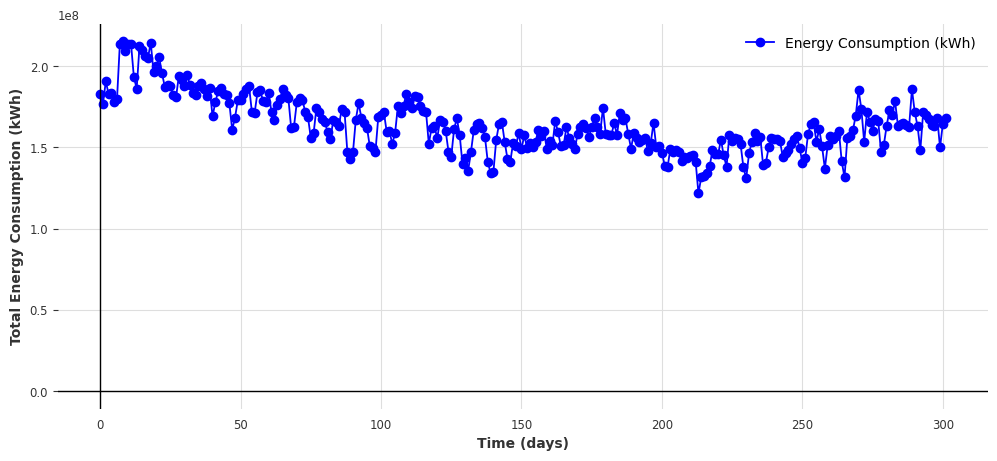

In [16]:
energy_consumption_data = df['Total Energy Consumption (kWh)'].dropna().values 
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 5))
plt.plot(energy_consumption_data, label="Energy Consumption (kWh)", color='blue', marker='o')
plt.xlabel('Time (days)')
plt.axhline(0, color='black', linewidth=1)
plt.axvline(0, color='black', linewidth=1)
plt.ylabel("Total Energy Consumption (kWh)")
plt.legend()
plt.show()



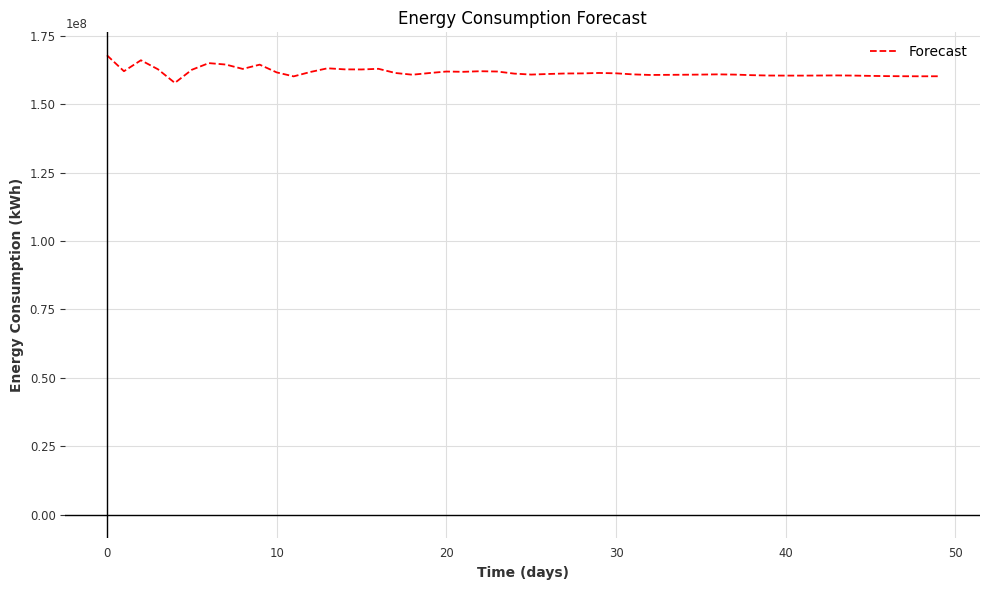

In [17]:
import numpy as np
forecast_periods = 50
plt.figure(figsize=(10, 6))
plt.plot(forecast[:forecast_periods], label='Forecast', color='red', linestyle='--')

plt.ylabel('Energy Consumption (kWh)')
plt.title('Energy Consumption Forecast')
plt.xlabel('Time (days)')
plt.axhline(0, color='black', linewidth=1)
plt.axvline(0, color='black', linewidth=1)

plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Going to create a combined dataset: 300 last actual points and 50 forecasted points


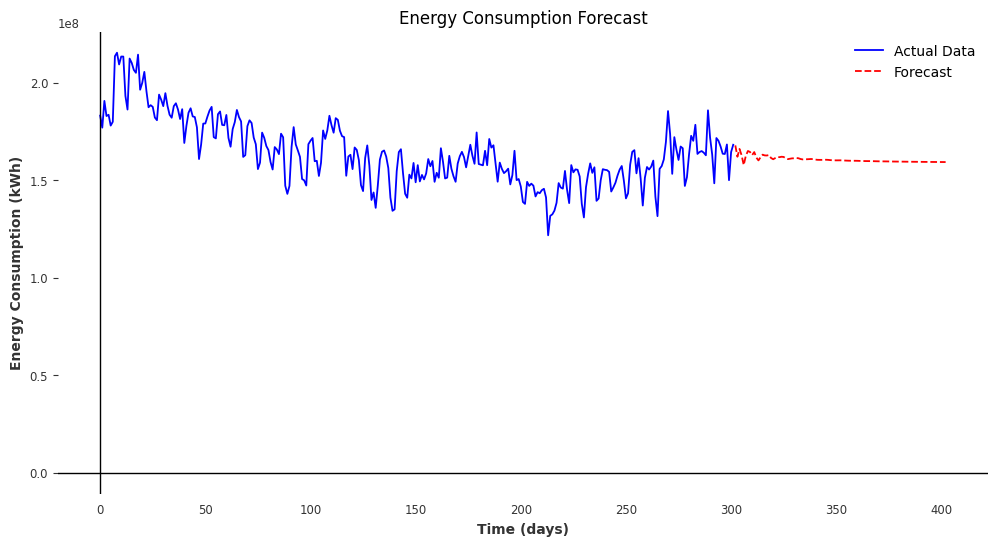

In [18]:
combined_data = np.concatenate((energy_consumption_data, forecast))

plt.figure(figsize=(12, 6))

plt.plot(energy_consumption_data, label='Actual Data', color='blue')
plt.plot(np.arange(len(energy_consumption_data), len(combined_data)), forecast, label='Forecast', color='red', linestyle='--')
plt.ylabel('Energy Consumption (kWh)')
plt.title('Energy Consumption Forecast')
plt.xlabel('Time (days)')
plt.axhline(0, color='black', linewidth=1)
plt.axvline(0, color='black', linewidth=1)
plt.legend()
plt.grid()
plt.show()


on teste avec lag = 30

In [19]:
model = AutoReg(energy_consumption_data, lags=30)  
forecast = model_fitted.predict(start=len(energy_consumption_data), end=len(energy_consumption_data) + 100)

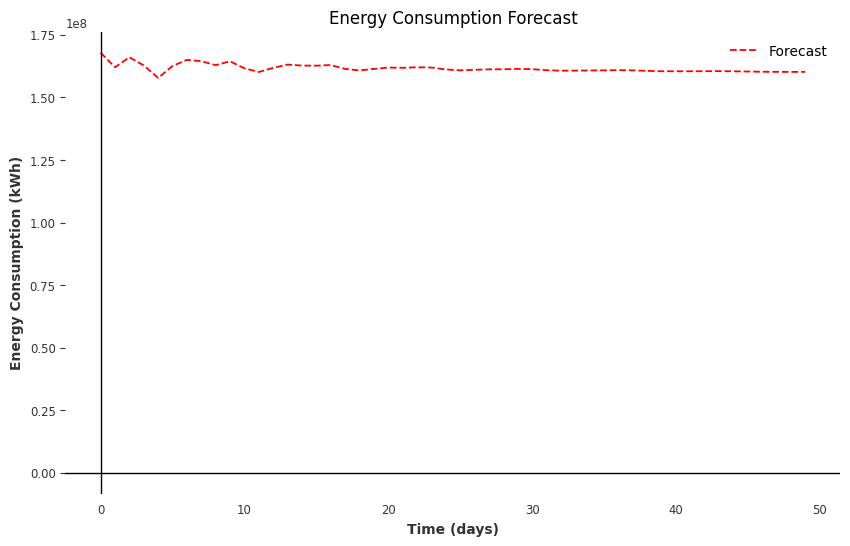

In [20]:
import numpy as np
forecast_periods = 50
plt.figure(figsize=(10, 6))
plt.plot(forecast[:forecast_periods], label='Forecast', color='red', linestyle='--')

plt.ylabel('Energy Consumption (kWh)')
plt.title('Energy Consumption Forecast')
plt.xlabel('Time (days)')
plt.axhline(0, color='black', linewidth=1)
plt.axvline(0, color='black', linewidth=1)
plt.legend()
plt.grid()
plt.show()

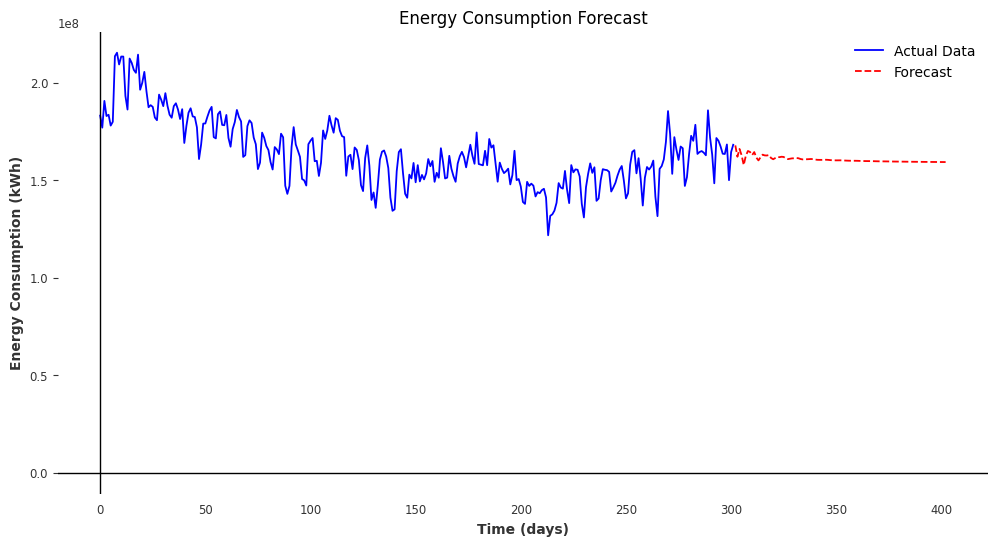

In [21]:
combined_data = np.concatenate((energy_consumption_data, forecast))

plt.figure(figsize=(12, 6))

plt.plot(energy_consumption_data, label='Actual Data', color='blue')
plt.plot(np.arange(len(energy_consumption_data), len(combined_data)), forecast, label='Forecast', color='red', linestyle='--')
plt.ylabel('Energy Consumption (kWh)')
plt.title('Energy Consumption Forecast')
plt.xlabel('Time (days)')
plt.axhline(0, color='black', linewidth=1)
plt.axvline(0, color='black', linewidth=1)
plt.legend()
plt.grid()
plt.show()


Vector Auto-regression

Je vais utiliser statsmodels pour VAR

Data cleaning, converts everything to numeric, replacing errors with NaN

In [22]:
print(df)

             Total Energy Consumed by End Users (kWh)  \
Zeitstempel                                             
2024-01-01                               1.361635e+08   
2024-01-02                               1.475919e+08   
2024-01-03                               1.529386e+08   
2024-01-04                               1.580906e+08   
2024-01-05                               1.654799e+08   
...                                               ...   
2024-10-24                               1.500636e+08   
2024-10-25                               1.489362e+08   
2024-10-26                               1.313286e+08   
2024-10-27                               1.238037e+08   
2024-10-28                               1.463964e+08   

             Total Energy Production (kWh)  Total Energy Consumption (kWh)  \
Zeitstempel                                                                  
2024-01-01                    1.296562e+08                    1.831487e+08   
2024-01-02              

In [23]:
df = df.apply(pd.to_numeric, errors='coerce') 

Only going to consider first 6 rows

In [24]:
df = df.iloc[:, :6]

In [25]:
df_cleaned = df.dropna()

Split testing 20-80 ish

In [26]:
test_total = int(0.2*300)

In [27]:
train_data = df.iloc[:-test_total]  
test_data = df.iloc[-test_total:]  

Initialize VAR model

In [28]:
from statsmodels.tsa.api import VAR
model = VAR(train_data)

choose how many last values to rely on: here =5

In [29]:
print(df.shape)  

(302, 6)


In [30]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
df_scaled = scaler.fit_transform(df)  


In [31]:
p = 6
fitted_model = model.fit(p) 

forecast next 20%

In [32]:
forecast = fitted_model.forecast(train_data.values[-p:], steps=test_total) 

In [33]:
correlation_matrix = df.corr()
print(correlation_matrix)


                                          Total Energy Consumed by End Users (kWh)  \
Total Energy Consumed by End Users (kWh)                                  1.000000   
Total Energy Production (kWh)                                            -0.066296   
Total Energy Consumption (kWh)                                            0.897156   
Net Outflow (kWh)                                                         0.357776   
Grid Feed-In (kWh)                                                       -0.024359   
Positive Secondary Control Energy (kWh)                                   0.345455   

                                          Total Energy Production (kWh)  \
Total Energy Consumed by End Users (kWh)                      -0.066296   
Total Energy Production (kWh)                                  1.000000   
Total Energy Consumption (kWh)                                -0.194490   
Net Outflow (kWh)                                             -0.540185   
Grid Feed-In (kWh)    

Trouver tout les variables très corrolées

In [34]:
correlation_threshold = 0.9
high_correlation = correlation_matrix.abs() > correlation_threshold
print(high_correlation)

                                          Total Energy Consumed by End Users (kWh)  \
Total Energy Consumed by End Users (kWh)                                      True   
Total Energy Production (kWh)                                                False   
Total Energy Consumption (kWh)                                               False   
Net Outflow (kWh)                                                            False   
Grid Feed-In (kWh)                                                           False   
Positive Secondary Control Energy (kWh)                                      False   

                                          Total Energy Production (kWh)  \
Total Energy Consumed by End Users (kWh)                          False   
Total Energy Production (kWh)                                      True   
Total Energy Consumption (kWh)                                    False   
Net Outflow (kWh)                                                 False   
Grid Feed-In (kWh)    

In [35]:
forecast_df = pd.DataFrame(forecast, index=test_data.index, columns=test_data.columns)

I'm going to compare forecast with actual data for the same rows

In [36]:
from statsmodels.tools.eval_measures import rmse

print("Forecast:")
print(forecast_df)


Forecast:
             Total Energy Consumed by End Users (kWh)  \
Zeitstempel                                             
2024-08-30                               1.390923e+08   
2024-08-31                               1.284448e+08   
2024-09-01                               1.262921e+08   
2024-09-02                               1.311247e+08   
2024-09-03                               1.333120e+08   
2024-09-04                               1.341541e+08   
2024-09-05                               1.371821e+08   
2024-09-06                               1.366374e+08   
2024-09-07                               1.313126e+08   
2024-09-08                               1.307943e+08   
2024-09-09                               1.335621e+08   
2024-09-10                               1.341484e+08   
2024-09-11                               1.351550e+08   
2024-09-12                               1.372397e+08   
2024-09-13                               1.361046e+08   
2024-09-14           

Root mean square deviation for average difference between values predicted by a model and the actual values

In [37]:
rmse_score = rmse(test_data, forecast_df)
print(f"RMSE: {rmse_score}")

RMSE: [11860075.17181351 28123002.44071378 10559572.3391376   3455261.99716615
 25410893.23157295   159672.99302088]


In [38]:
def plot_actual_vs_forecasted(col):
    fig, ax = plt.subplots(figsize=(14, 6))
    ax.plot(test_data.index,     test_data[col],     '--', color='blue', label=f'Actual {col}')
    ax.plot(forecast_df.index, forecast_df[col], '-',  color='red',  label=f'Forecast {col}')

    ax.set_title(f'Actual vs Forecasted {col}', fontsize=16)
    ax.set_xlabel('Date', fontsize=14)
    ax.set_ylabel(col, fontsize=14)
    ax.axhline(0, color='black', linewidth=1)
    ax.axvline(test_data.index[0], color='black', linewidth=1)
    ax.grid(True)
    ax.legend(loc='upper left')
    plt.tight_layout()
    plt.show()

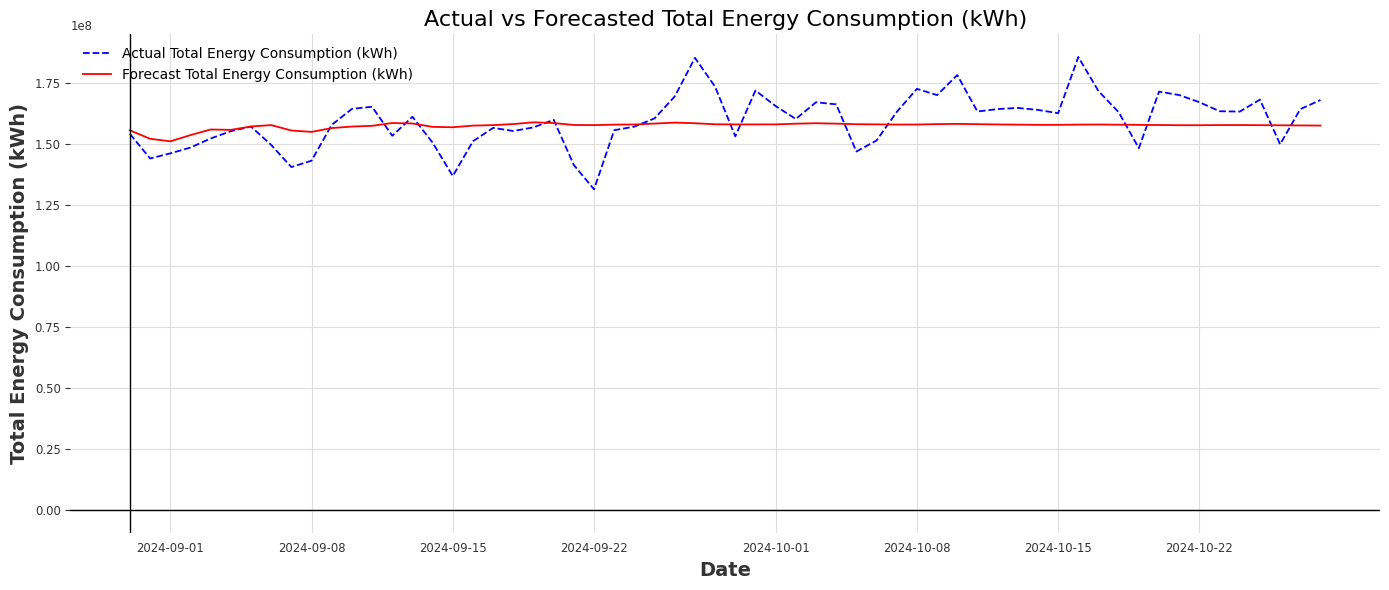

In [39]:
plot_actual_vs_forecasted('Total Energy Consumption (kWh)')

In [40]:
"""for col in forecast_df.columns[:3]:
    plot_actual_vs_forecasted(col)"""

'for col in forecast_df.columns[:3]:\n    plot_actual_vs_forecasted(col)'

**III: Time Series Analysis**

**III. 1. Stationarity of my Time Series**

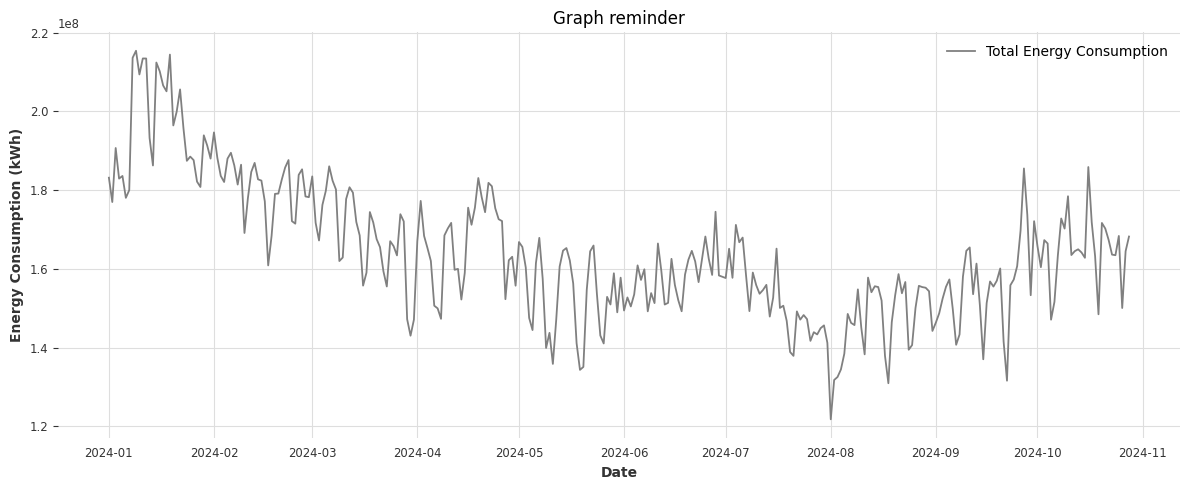

In [41]:
fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(df['Total Energy Consumption (kWh)'], label='Total Energy Consumption', color='gray')
ax.set_title('Graph reminder')
ax.set_xlabel('Date')
ax.set_ylabel('Energy Consumption (kWh)')
ax.legend()
ax.grid(True)
plt.tight_layout()
plt.show()

To-do: forecast par semaine, dépend de swissgrid, 

Ecrire chaque concept dans le rapport

graph de xt+i - xt

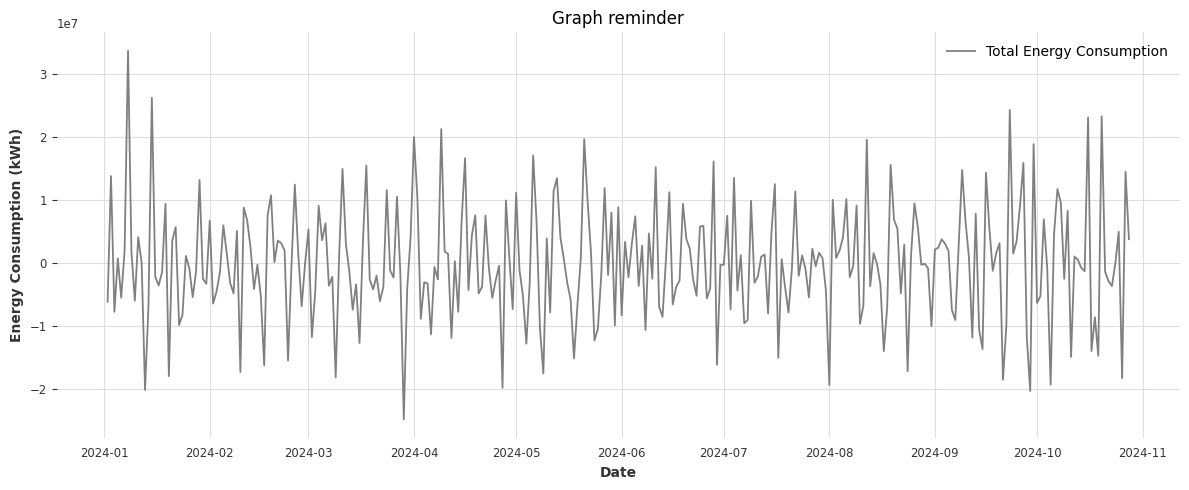

In [42]:
fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(df['Total Energy Consumption (kWh)'].diff(), label='Total Energy Consumption', color='gray')
ax.set_title('Graph reminder')
ax.set_xlabel('Date')
ax.set_ylabel('Energy Consumption (kWh)')
ax.legend()
ax.grid(True)
plt.tight_layout()
plt.show()

**III. 1.a. Informal check**

**III. 1.a. i. Mean Calculation**

Calculating the mean of my time series (Total Power Consumption in the Grid)

the formula for the mean is: μ = (x₁ + x₂ + ... + xₙ) / n

In [43]:
def mean(data):
    return sum(data) / len(data)

In [44]:
print(mean(energy_consumption_data))

164137548.03643206


**III. 1.a. ii. Variance Calculation**

Calculating Variance:

Variance = 1/n sum(xi- mean)**2

In [45]:
def variance(data):
    mean_value = mean(data)
    variance = sum((x - mean_value)**2 for x in data) / len(data)
    return variance

In [46]:
print(variance(energy_consumption_data))

296045100981604.75


**III. 1.a. iii. Autocorrelation Calculation**

In [47]:
from statsmodels.tsa.stattools import acf

autocorrelation function (ACF) at lag k, for k ≥ 0, of the time series is defined by
rk = sk/ s0 where sk is the autocovariance at lag k

In [48]:
alpha = 0.05
confint = 1 - alpha
nlags = 100

In [49]:
def check_autocorrelation(data, nlags=10, alpha=0.05):
    data = np.asarray(data)
    acf_vals, _ = acf(data, nlags=nlags, alpha=alpha, fft=False) 
    return acf_vals


In [50]:
acf_vals = check_autocorrelation(energy_consumption_data, nlags=nlags)

In [51]:
print(f"High Autocorrelation defined as {1 - alpha}")
for lag in range(1, nlags + 1):
    print(f"lag {lag:2d} → ACF = {acf_vals[lag]: .4f}")

High Autocorrelation defined as 0.95
lag  1 → ACF =  0.8587
lag  2 → ACF =  0.7447
lag  3 → ACF =  0.6998
lag  4 → ACF =  0.6843
lag  5 → ACF =  0.6775
lag  6 → ACF =  0.7458
lag  7 → ACF =  0.7900
lag  8 → ACF =  0.7222
lag  9 → ACF =  0.6527
lag 10 → ACF =  0.6083
lag 11 → ACF =  0.5707
lag 12 → ACF =  0.5710
lag 13 → ACF =  0.6205
lag 14 → ACF =  0.6497
lag 15 → ACF =  0.5914
lag 16 → ACF =  0.5143
lag 17 → ACF =  0.4789
lag 18 → ACF =  0.4487
lag 19 → ACF =  0.4569
lag 20 → ACF =  0.5034
lag 21 → ACF =  0.5266
lag 22 → ACF =  0.4655
lag 23 → ACF =  0.4148
lag 24 → ACF =  0.3833
lag 25 → ACF =  0.3600
lag 26 → ACF =  0.3630
lag 27 → ACF =  0.4158
lag 28 → ACF =  0.4341
lag 29 → ACF =  0.3953
lag 30 → ACF =  0.3412
lag 31 → ACF =  0.3080
lag 32 → ACF =  0.2964
lag 33 → ACF =  0.3024
lag 34 → ACF =  0.3602
lag 35 → ACF =  0.3978
lag 36 → ACF =  0.3490
lag 37 → ACF =  0.2832
lag 38 → ACF =  0.2545
lag 39 → ACF =  0.2466
lag 40 → ACF =  0.2566
lag 41 → ACF =  0.3246
lag 42 → ACF =  0.35

Setting axis at 0

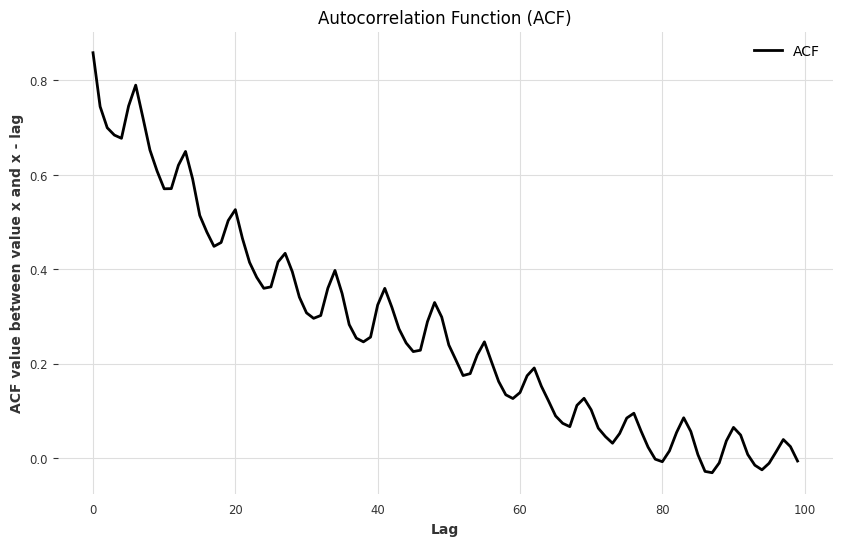

In [52]:
acf_series = TimeSeries.from_values(acf_vals[1:])
plt.figure(figsize=(10, 6))
acf_series.plot(label="ACF")
plt.title("Autocorrelation Function (ACF)")
plt.xlabel("Lag")
plt.ylabel("ACF value between value x and x - lag")
plt.legend(loc="upper right")
plt.show()

**III. 1.a. iv. Informal check using mean, variance**

Informal Test: check if mean, variance are constants

In [53]:
def check_mean_variance(data):
    n = len(data)
    first_half = data[:n//2]
    second_half = data[n//2:]
    
    mean1, var1 = mean(first_half), variance(first_half)
    mean2, var2 = mean(second_half), variance(second_half)
    
    print(f'First half mean: {mean1}, variance: {var1}')
    print(f'Second half mean: {mean2}, variance: {var2}')


In [54]:
check_mean_variance(energy_consumption_data)

First half mean: 173067122.12533218, variance: 317776238135326.44
Second half mean: 155207973.9475321, variance: 114839377009570.05


If (Xt) is strictly stationary, then: